<a href="https://colab.research.google.com/github/MRUusmae/marketing_models/blob/main/MRU_A_B_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#A/B Testing - a quick look

A/B Testing is used to evaluate if a change is impactful or not.
Let's say if you change the design of a checkout page - hoping your change would lower the amount of abandoned carts.
In this notebook - I'll walk though a case study and help evaluate it -as well as adding useful comments on the stuff around the A/B test that you will want to be mindful of.

#Scenario

Imagine you're working at an ad agency, and you are tasked with testing the effectiveness of the SmartAd ads the company has built.

They want to ensure, with 95% confidence, that the SmartAds they've built, lead to at least 5% more interactions than the old/dummy ads.

#Desigining the experiment

As you can imagine, there are multiple ways to go about this, and one way can be to carry out an A/B test to see if they are more effective.

The effectiveness can be evaluated in multiple ways, but in this case, the website is set up in a way where they can host the SmartAd ads (as well as dummy ads to as a control group) and selectively show one or the other ad and measure some metrics.
Based on the ad, they would get a questionnaire, and their options would be to respond in yes, no, or not respond.
These are the constraints in where you can set up your experiement.


Potential ways to evaluate the effectiveness:
1.   Look at the amount of BIO questionnaire responses (vs no response)
2.   Positive interation vs a negative interaction for the ad.

Lets move forward with **option 1** for now.

For Evaluation, best practice is to define your measurement methods before you run the test.
As your results can be better or worse, you might want to use a two-tailed test.

In this case, the common null hypothesis is that the (interactions with the) SmartAd is not statistically significantly different from the dummy ads. (Which doesn't necessarily mean that they're the same - you just can't observe a difference).
$$H_0: p = p_0$$
$$H_a: p \ne p_0$$
Your alternative hypothesis is that the SmartAds perform differently to dummy ads.
A common confidence level to select is these tests is 95%, and so 1- 0.95 leads to:
$$\alpha = 0.05$$

The $\alpha$ value is a threshold we set, by which we say "if the probability of observing a result as extreme or more ($p$-value) is lower than $\alpha$, then we reject the null hypothesis". Since our $\alpha=0.05$ (indicating 5% probability), our confidence (1 - $\alpha$) is 95%.




---

It's an A/B test, hence you need to define your A & B, the variables that you're trying to control for.
There's going to be the


*   A - Group - the control group - in this case, the dummy ads
*   B - Group - the treatment group - in this case, the SmartAd ads

This can be called our *independent variable*
Although we might know priors about dummy ads - the control group is critical to have a like-for-like comparison dataset that is impacted by the same influences as the treatment groups for as much of them you can control for (seasonality, days of the week, even demographics where available)

Our dependent variable variable will be the effectiveness measure we've defined eralier, the interactions value.


---

In order to carry out the experiment (and data collection), a key businesss question is always: how much data is sufficient to evaluate it?
More data means longer experiements - so you want your experiment to be just long enough to get enough data, while accounting for the potential impact of the time periods you're looking at (like weekends vs weekdays can give different results)

*How long is long enough?*
That's based on the minimum number of samples required to establish the impact you're trying to evaluate - smaller impact required more data to confidently identify.
The number of minimum samples required can come from **Power Analysis**, which depends on:

* **Power of the test** ($1 - \beta$) - This represents the probability of finding a statistical difference between the groups in our test when a difference is actually present. Usually set at 0.8.
* **Alpha value** ($\alpha$) - The alpha value we set earlier to 0.05
* **Effect size** - How big of a difference are we expecting - that came from the team, expecting an improvement of at least 5% hence 0.05.

In terms of estimating the sample size, a much more accurate estimate can be made if we have an expected value for the effect (i.e. 20% of people are going to interact, and we are aiming for 25).

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

alpha = 0.05
power = 0.8

current_effect = 0.2
expected_improvement = 0.05

effect_size = sms.proportion_effectsize(current_effect, current_effect + expected_improvement)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size,
    power=power,
    alpha=alpha,
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number

f"A minimum of {required_n} samples (in each group) are required"

'A minimum of 1092 samples (in each group) are required'

#Collected Data

The Scenario is based on the Ad A/B Testing dataset available on [Kaggle](https://www.kaggle.com/datasets/osuolaleemmanuel/ad-ab-testing/data)

It is described in the following way:

**auction_id**: the unique id of the online user who has been presented the BIO. In standard terminologies this is called an impression id. The user may see the BIO questionnaire but choose not to respond. In that case both the yes and no columns are zero.

**experiment**: which group the user belongs to - control or exposed.

control: users who have been shown a dummy ad
exposed: users who have been shown a creative, an online interactive ad, with the SmartAd brand.
**date**: the date in YYYY-MM-DD format

**hour**: the hour of the day in HH format.

**device_make**: the name of the type of device the user has e.g. Samsung

**platform_os**: the id of the OS the user has.

**browser**: the name of the browser the user uses to see the BIO questionnaire.

**yes**: 1 if the user chooses the “Yes” radio button for the BIO questionnaire.

**no**: 1 if the user chooses the “No” radio button for the BIO questionnaire.

In [3]:
import pandas as pd

In [4]:
!kaggle datasets download -d osuolaleemmanuel/ad-ab-testing
!unzip ad-ab-testing.zip

Dataset URL: https://www.kaggle.com/datasets/osuolaleemmanuel/ad-ab-testing
License(s): CC-BY-SA-3.0
  0% 0.00/216k [00:00<?, ?B/s]
100% 216k/216k [00:00<00:00, 32.9MB/s]
Archive:  ad-ab-testing.zip
  inflating: AdSmartABdata - AdSmartABdata.csv  


In [5]:
raw_dataset = pd.read_csv('/content/AdSmartABdata - AdSmartABdata.csv')
raw_dataset
# auction_id is essentially an impressiod_id - and should be unique

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
...,...,...,...,...,...,...,...,...,...
8072,ffea24ec-cec1-43fb-b1d1-8f93828c2be2,exposed,2020-07-05,7,Generic Smartphone,6,Chrome Mobile,0,0
8073,ffea3210-2c3e-426f-a77d-0aa72e73b20f,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
8074,ffeaa0f1-1d72-4ba9-afb4-314b3b00a7c7,control,2020-07-04,9,Generic Smartphone,6,Chrome Mobile,0,0
8075,ffeeed62-3f7c-4a6e-8ba7-95d303d40969,exposed,2020-07-05,15,Samsung SM-A515F,6,Samsung Internet,0,0


In [6]:
raw_dataset.auction_id.nunique() # auction_id is a unique identifier

8077

In [7]:
raw_dataset.groupby('experiment').count()
#roughly equally split between the control and test set

,auction_id,date,hour,device_make,platform_os,browser,yes,no
experiment,,,,,,,,
control,4071,4071,4071,4071,4071,4071,4071,4071
exposed,4006,4006,4006,4006,4006,4006,4006,4006


In [8]:
raw_dataset.date.unique() # roughly a week of data

array(['2020-07-10', '2020-07-07', '2020-07-05', '2020-07-03',
       '2020-07-09', '2020-07-04', '2020-07-06', '2020-07-08'],
      dtype=object)

In [9]:
control_sample = raw_dataset[raw_dataset['experiment'] == 'control'].sample(n=required_n, random_state=42)
treatment_sample = raw_dataset[raw_dataset['experiment'] == 'exposed'].sample(n=required_n, random_state=42)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

ab_test['interaction'] = 0
ab_test.loc[(ab_test.yes + ab_test.no) > 0, 'interaction'] = 1

ab_test_filtered = ab_test[['experiment','date','interaction']]
ab_test_filtered

,experiment,date,interaction
0,control,2020-07-05,0
1,control,2020-07-03,1
2,control,2020-07-03,0
3,control,2020-07-04,1
4,control,2020-07-09,0
...,...,...,...
2179,exposed,2020-07-03,0
2180,exposed,2020-07-08,1
2181,exposed,2020-07-06,0
2182,exposed,2020-07-08,0


We have prepared and filtered the data, now we can procees with the analysis.


---



#Analysis

In [10]:
import pandas as pd
import numpy as np
from scipy import stats

# Assuming ab_test is your DataFrame
interaction_rates = (
    ab_test_filtered.groupby('experiment')['interaction']
    .agg(
        interaction_rate=np.mean,
        std_deviation=lambda x: np.std(x, ddof=0),
        std_error=lambda x: stats.sem(x, ddof=0)
    )
    .style.format('{:.3f}')
)

interaction_rates

,interaction_rate,std_deviation,std_error
experiment,,,
control,0.147,0.355,0.011
exposed,0.170,0.376,0.011


Judging by the stats above, it does look like **the new design has a slightly different interaction rate**, with our new SmartAds performing slightly better, approx. **14.7% vs. 17.0% interaction rate**.


<Axes: xlabel='experiment', ylabel='interaction'>

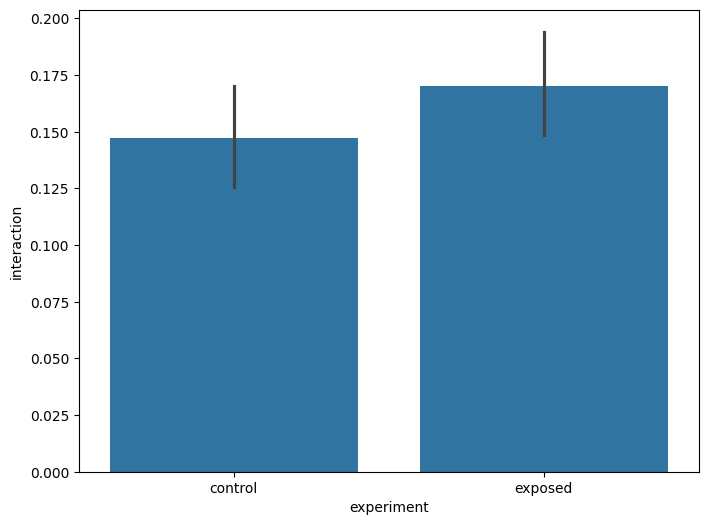

In [11]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test_filtered['experiment'], y=ab_test_filtered['interaction'])

So, we can crearly see a difference in the data, but is it statistically significant, or is it more likely to just be randomness?

#Testing the hypothesis

The last step of our analysis is testing our hypothesis. Since we have a large sample, we can use the normal approximation for calculating our $p$-value (i.e. z-test).



In [12]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = ab_test_filtered[ab_test_filtered['experiment'] == 'control']['interaction']
treatment_results = ab_test_filtered[ab_test_filtered['experiment'] == 'exposed']['interaction']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for exposed group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -1.46
p-value: 0.143
ci 95% for control group: [0.126, 0.168]
ci 95% for exposed group: [0.148, 0.193]


Our $p$-value=0.143 is above our $\alpha$=0.05, we cannot reject the null hypothesis $H_0$, which means that our new design did not perform significantly differently.

Although we cannot reject the null hypothesis, we can see the 95%ile confidence intervals for the 2 groups have overlap, but they could be 2 somewhat overlapping distributions, and the impact we might be actually measuring is smaller than expected, so the sample size reuired to establish that would likely be bigger.


#Further analysis

In [13]:
len(raw_dataset), len(ab_test_filtered) #looks like we could make use of more data to evaluate the impact

(8077, 2184)

As we are currently making use of 2.1k datapoints, and we have ~8k total datapoints, we can easily double or triple the number of datapoints we use for our analysis.

In [14]:
new_control = raw_dataset[raw_dataset['experiment'] == 'control'].sample(n=required_n*3, random_state=42)
new_exposed = raw_dataset[raw_dataset['experiment'] == 'exposed'].sample(n=required_n*3, random_state=42)

ab_test_expanded = pd.concat([new_control, new_exposed], axis=0)
ab_test_expanded.reset_index(drop=True, inplace=True)

ab_test_expanded['interaction'] = 0
ab_test_expanded.loc[(ab_test_expanded.yes + ab_test_expanded.no) > 0, 'interaction'] = 1

ab_test_expanded = ab_test_expanded[['experiment','date','interaction']]
ab_test_expanded

,experiment,date,interaction
0,control,2020-07-05,0
1,control,2020-07-03,1
2,control,2020-07-03,0
3,control,2020-07-04,1
4,control,2020-07-09,0
...,...,...,...
6547,exposed,2020-07-09,0
6548,exposed,2020-07-05,0
6549,exposed,2020-07-05,1
6550,exposed,2020-07-05,0


In [15]:
# Assuming ab_test is your DataFrame
interaction_rates_expanded = (
    ab_test_expanded.groupby('experiment')['interaction']
    .agg(
        interaction_rate=np.mean,
        std_deviation=lambda x: np.std(x, ddof=0),
        std_error=lambda x: stats.sem(x, ddof=0)
    )
    .style.format('{:.3f}')
)

interaction_rates_expanded

,interaction_rate,std_deviation,std_error
experiment,,,
control,0.141,0.348,0.006
exposed,0.161,0.368,0.006


The interaction rates with the increased datasets have slightly changes, but we can still observe a difference.

In [16]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results_expanded = ab_test_expanded[ab_test_expanded['experiment'] == 'control']['interaction']
exposed_results_expanded = ab_test_expanded[ab_test_expanded['experiment'] == 'exposed']['interaction']

n_con = control_results_expanded.count()
n_treat = exposed_results_expanded.count()
successes = [control_results_expanded.sum(), exposed_results_expanded.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for exposed group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -2.35
p-value: 0.019
ci 95% for control group: [0.129, 0.153]
ci 95% for exposed group: [0.149, 0.174]


Our $p$-value=0.019 is above our $\alpha$=0.05, hence we **can** now reject the null hypothesis $H_0$, which means the chance of us observing this difference with this amount of samples shows that it's less that 5% change it's by random chance.

The confidence intervals show us that we are not in the ~20% interaction rate as expected by the team, but closer to the 12.9% - 15.3% range for the dummy data, and 14.9 - 17.4% for the new ads.



In [20]:
control_mean = (lower_con +  upper_con) / 2
exposed_mean = (lower_treat + upper_treat) / 2

increase = (exposed_mean - control_mean)  / control_mean
increase

0.14750542299349248

Taking the upper and lower bounds of the confidence intervals, we can calculate the mean for the control and exposed groups, and use those to establish the lift due to the new ads. We can observe an increase in interaction of **14.8%**

**Success!**